### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [19]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [21]:
COLUMNS_TO_DROP = [
#     "Unnamed: 0",
#     "trans_num",
#     "trans_date_trans_time", # TODO: we need to split it to bins of day
    
#     "first", "last", # TODO: we can think to identify nationality by name
] 

def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

def get_categorical_features(df):
    return df.select_dtypes(include=['object'])

def read_test_data():
    return drop_columns(read_data("fraudTest.csv"), COLUMNS_TO_DROP)

def read_data(file_name):
    return pd.read_csv(file_name)

def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1,errors='ignore')

In [22]:
features_description = {
'transdatetrans_time' : 'Transaction DateTime',
'cc_num' : 'Credit Card Number of Customer',
'merchant' : 'Merchant Name',
'category' : 'Category of Merchant',
'amt' : 'Amount of Transaction',
'first' : 'First Name of Credit Card Holder',
'last' : 'Last Name of Credit Card Holder',
'gender' : 'Gender of Credit Card Holder',
'street' : 'Street Address of Credit Card Holder',
'city' : 'City of Credit Card Holder',
'state' : 'State of Credit Card Holder',
'zip' : 'Zip of Credit Card Holder',
'lat' : 'Latitude Location of Credit Card Holder',
'long' : 'Longitude Location of Credit Card Holder',
'city_pop' : 'Credit Card Holder City Population',
'job' : 'Job of Credit Card Holder',
'dob' :'Date of Birth of Credit Card Holder',
'trans_num' : 'Transaction Number',
'unix_time' : 'UNIX Time of transaction',
'merch_lat' : 'Latitude Location of Merchant',
'merch_long' : 'Longitude Location of Merchant',
'is_fraud' : 'Fraud Flag'
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [23]:
#### trans_date_trans_time to trans_date_category ####

def get_hour_as_category(hour):
        day_time_category = "night"
        
        if 6 <= hour and hour < 12: 
            day_time_category = "morning"
        elif hour >=12 and hour < 18:
            day_time_category = "afternoon"
        elif hour >= 18 and hour < 22:
            day_time_category = "evening"
            
        return day_time_category

def convert_to_categorical_trans_date(df):
    _df = df.copy()
    trans_date_category_list = []
    
    for  i, d in enumerate(get_categorical_features(_df).trans_date_trans_time):
        day_of_week = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%A');
        hour = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').hour
        trans_date_category = "{}_{}".format(day_of_week, hour)
        trans_date_category_list.append(trans_date_category)
    
    _df['trans_date_category'] = trans_date_category_list
    return _df

def convert_to_categorical_trans_date_and_drop(df):
    converted_df = convert_to_categorical_trans_date(df)
    return drop_columns(converted_df, ["trans_date_trans_time"])

In [24]:
#### city_pop to city_pop_category ####

def population_as_category(p):
    category = "2M+"
    
    if p <= 100:
        category = "100-"
    elif p <= 500:
        category = "500-"
    elif p <= 1000:
        category = "1K-"
    elif p <= 2000:
        category = "2K-"
    elif p <= 3000:
        category = "3K-"
    elif p <= 5000:
        category = "5K-"
    elif p <= 10000:
        category = "10K-"
    elif p <= 30000:
        category = "30K-"
    elif p <= 50000:
        category = "50K-"
    elif p <= 100000:
        category = "100K-"
    elif p <= 200000:
        category = "200K-"
    elif p <= 500000:
        category = "500K-"
    elif p <= 1000000:
        category = "1M-"
    elif p <= 1500000:
        category = "1.5M-"
    elif p <= 2000000:
        category = "2M-"
        
    return category

def convert_to_categorical_city_pop(df):
    _df = df.copy()
    city_pop_category_list = []
    
    for p in df.city_pop:
        category = population_as_category(p)
        city_pop_category_list.append(category)
        
    _df['city_pop_category'] = city_pop_category_list
    return _df

In [25]:
def convert_cc_to_cc_type_and_drop(df):
    _df = convert_cc_to_cc_type(df)
    return drop_columns(_df, ["cc_num"])

def convert_cc_to_cc_type(df):
    _df = df.copy()
    cc_category_list = []
    
    for cc in df.cc_num:
        cc_category_list.append(get_cc_type(cc))
        
    _df['cc_type'] = cc_category_list
    return _df

def get_cc_type(cc_number):
    cc_number = str(cc_number)
    if is_american_express(cc_number): return 'AMEX'
    if is_visa(cc_number): return 'VISA'
    if is_mastercard(cc_number): return 'MasterCard'
    if is_discover(cc_number): return 'Discover'
    if is_jcb(cc_number): return 'JCB'
    if is_diners_club(cc_number): return 'DinersClub'
    if is_laser(cc_number): return 'Laser'
    if is_maestro(cc_number): return 'Maestro'
    if is_visa_electron(cc_number): return 'VisaElectron'
    if is_total_rewards_visa(cc_number): return 'TotalRewardsVisa'
    if is_diners_club_carte_blanche(cc_number): return 'DinersClubCarteBlanche'
    if is_diners_club_carte_international(cc_number): return 'DinersClubCarteInt'
    
    return 'unknown'

def is_american_express(cc_number):
    """Checks if the card is an american express. If us billing address country code, & is_amex, use vpos
    https://en.wikipedia.org/wiki/Bank_card_number#cite_note-GenCardFeatures-3
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3[47][0-9]{13}$', cc_number))


def is_visa(cc_number):
    """Checks if the card is a visa, begins with 4 and 12 or 15 additional digits.
    :param cc_number: unicode card number
    """

    # Standard Visa is 13 or 16, debit can be 19
    if bool(re.match(r'^4', cc_number)) and len(cc_number) in [13, 16, 19]:
        return True

    return False


def is_mastercard(cc_number):
    """Checks if the card is a mastercard. Begins with 51-55 or 2221-2720 and 16 in length.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16 and cc_number.isdigit():  # Check digit, before cast to int
        return bool(re.match(r'^5[1-5]', cc_number)) or int(cc_number[:4]) in range(2221, 2721)
    return False


def is_discover(cc_number):
    """Checks if the card is discover, re would be too hard to maintain. Not a supported card.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16:
        try:
            # return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or cc_number[:6] in range(622126, 622926))
            return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or 622126 <= int(cc_number[:6]) <= 622925)
        except ValueError:
            return False
    return False


def is_jcb(cc_number):
    """Checks if the card is a jcb. Not a supported card.
    :param cc_number: unicode card number
    """
    # return bool(re.match(r'^(?:2131|1800|35\d{3})\d{11}$', cc_number))  # wikipedia
    return bool(re.match(r'^35(2[89]|[3-8][0-9])[0-9]{12}$', cc_number))  # PawelDecowski


def is_diners_club(cc_number):
    """Checks if the card is a diners club. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3(?:0[0-6]|[68][0-9])[0-9]{11}$', cc_number))  # 0-5 = carte blance, 6 = international


def is_laser(cc_number):
    """Checks if the card is laser. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(6304|670[69]|6771)', cc_number))


def is_maestro(cc_number):
    """Checks if the card is maestro. Not a supported card.
    :param cc_number: unicode card number
    """
    possible_lengths = [12, 13, 14, 15, 16, 17, 18, 19]
    return bool(re.match(r'^(50|5[6-9]|6[0-9])', cc_number)) and len(cc_number) in possible_lengths


# Child cards

def is_visa_electron(cc_number):
    """Child of visa. Checks if the card is a visa electron. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(4026|417500|4508|4844|491(3|7))', cc_number)) and len(cc_number) == 16


def is_total_rewards_visa(cc_number):
    """Child of visa. Checks if the card is a Total Rewards Visa. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^41277777[0-9]{8}$', cc_number))


def is_diners_club_carte_blanche(cc_number):
    """Child card of diners. Checks if the card is a diners club carte blance. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^30[0-5][0-9]{11}$', cc_number))  # github PawelDecowski, jquery-creditcardvalidator


def is_diners_club_carte_international(cc_number):
    """Child card of diners. Checks if the card is a diners club international. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^36[0-9]{12}$', cc_number))  # jquery-creditcardvalidator

In [26]:
def get_partial_data(df, percent_of_data):
    return df.sample(frac=percent_of_data)

In [27]:
def convert_dob_to_age(df): # calculate age in days at the moment of transaction
    _df = df.copy()
    age_in_days = []
    
    for index, row in _df.iterrows():
        birth_date  = datetime.datetime.strptime(row['dob'], '%Y-%m-%d')
        trans_date  = datetime.datetime.strptime(row['trans_date_trans_time'],'%Y-%m-%d %H:%M:%S')
        age = trans_date - birth_date
        age_in_days.append(age.days)
    
    _df['age_in_days'] = age_in_days
    return _df

def convert_dob_to_age_and_drop(df):
    converted_df = convert_dob_to_age(df)
    return drop_columns(converted_df, ["dob"])

In [28]:
def unite_state_city(df):
    _df = df.copy()
    state_city_list = []
    
    for index, row in _df.iterrows():
        state_city = row['state'] + "_" + row['city']
        state_city_list.append(state_city)
        
    _df['city'] = state_city_list
    return _df

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [29]:
data = drop_columns(read_data("fraudTest.csv"), ["Unnamed: 0"])
df = data
# data = convert_cc_to_cc_type_and_drop(data)
# data = convert_dob_to_age_and_drop(data)
# data = unite_state_city(data)

In [30]:
fraud = data[data['is_fraud']==1]
normal = data[data['is_fraud']==0]

In [31]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [32]:
data.isnull().sum().max()

0

In [33]:
AMOUNT_OF_FRAUD = data['is_fraud'].value_counts()[1]
print('No Frauds', round(data['is_fraud'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['is_fraud'].value_counts()[1]/len(data) * 100,2), '% of the dataset')
print('Total amount of fraud transactions:', AMOUNT_OF_FRAUD)

No Frauds 99.61 % of the dataset
Frauds 0.39 % of the dataset
Total amount of fraud transactions: 2145


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

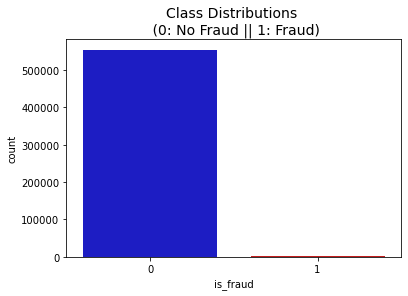

In [34]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('is_fraud', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

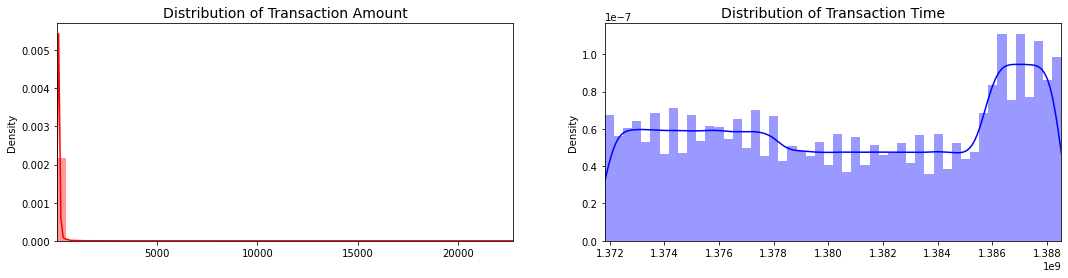

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amt'].values
time_val = df['unix_time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [37]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import RobustScaler

# RobustScaler is less prone to outliers.

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['amt'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['unix_time'].values.reshape(-1,1))

df.drop(['amt','unix_time'], axis=1, inplace=True)

In [38]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,trans_date_trans_time,cc_num,merchant,category,first,last,gender,street,...,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,-0.605478,-0.909209,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,Jeff,Elliott,M,351 Darlene Green,...,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,33.986391,-81.200714,0
1,-0.237803,-0.909208,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,Joanne,Williams,F,3638 Marsh Union,...,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,39.450498,-109.960431,0
2,-0.081902,-0.909206,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,Ashley,Lopez,F,9333 Valentine Point,...,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,40.495810,-74.196111,0
3,0.173889,-0.909204,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,28.812398,-80.883061,0
4,-0.600981,-0.909204,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,44.959148,-85.884734,0


In [39]:
### create balanced data set ###

df = df.sample(frac=1)

fraud_df = df.loc[df['is_fraud'] == 1]
non_fraud_df = df.loc[df['is_fraud'] == 0][:AMOUNT_OF_FRAUD]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

#new_df.head()
new_df

,scaled_amount,scaled_time,trans_date_trans_time,cc_num,merchant,category,first,last,gender,street,...,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
481645,-0.068956,0.644135,2020-12-15 09:20:20,213114122496591,"fraud_Reilly, Heaney and Cole",gas_transport,Jeremy,Perry,M,797 Jennifer Loop Suite 634,...,56068,43.8295,-93.8282,1087,Music tutor,1963-07-14,3b5f0fcb3d8dddb5bf1afb4326de6512,43.593336,-93.611379,0
403304,12.734533,0.482557,2020-11-26 23:45:54,30546453310167,fraud_Durgan-Auer,misc_net,Nicholas,Tran,M,672 Randall Burg Suite 551,...,3220,43.4512,-71.4890,7430,"Scientist, research (medical)",1955-01-13,2e4aea8fbf8268177847c4bf901e156f,42.707602,-72.442872,1
519314,0.385391,0.716066,2020-12-23 13:55:00,38199021865320,fraud_Gaylord-Powlowski,home,Jesse,Roberts,M,8415 Vaughn Squares Apt. 788,...,3601,43.1960,-72.3001,477,Naval architect,1988-04-15,d246c6f67bdcd88784f8b3ce86a8e91d,43.714293,-72.739219,0
47027,2.382120,-0.770718,2020-07-07 06:43:13,567868110212,fraud_Cartwright-Harris,grocery_pos,Dawn,Tucker,F,789 Herring Manors,...,77007,29.7736,-95.4034,2906700,"Copywriter, advertising",1984-12-16,241f2f78b4dd3fc2b4d1f3722d074411,30.126684,-95.162486,0
78632,0.440447,-0.667531,2020-07-19 00:42:56,213156747557083,fraud_Kuvalis Ltd,gas_transport,Adam,Santos,M,725 Jo Trace Apt. 102,...,91206,34.1556,-118.2322,172817,Advertising account planner,1982-07-30,3298793bfde48f62e90bc4f6c007186a,35.077526,-119.018215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550737,-0.498910,0.777385,2020-12-30 13:29:37,371284100299909,"fraud_Witting, Beer and Ernser",home,Hannah,Thomas,F,1004 Willis Pass,...,79237,34.8698,-100.6806,513,Early years teacher,1976-05-24,f7cead9183f7bdff153864d1d176a8cc,35.390980,-99.944175,0
309659,12.450259,0.122019,2020-10-16 22:27:38,3527063666782582,fraud_Dach-Nader,misc_net,Amanda,Alexander,F,21810 James Mall,...,75934,30.9000,-94.7547,99,Colour technologist,1965-11-21,59d5982ec6f77b151a4a2e4b72ac2a3d,31.175112,-94.042457,1
20565,0.078359,-0.846518,2020-06-28 15:34:00,4294040533480516,fraud_Renner Ltd,home,Gail,Weaver,F,979 Stewart Lake,...,29809,33.4130,-81.6900,2206,Biomedical scientist,1986-12-31,e2cfa25922f994bb90f1f7985f309e12,33.438255,-82.026536,0
274604,-0.561325,-0.015356,2020-10-01 07:01:55,4797297220948468262,fraud_Jaskolski-Vandervort,misc_net,Erica,Briggs,F,3310 Davidson Spurs Apt. 107,...,47451,38.8938,-86.5246,1228,Counsellor,1991-03-13,007d23eec0a76c0e72a6d5aa0d84cb6d,38.068719,-87.312204,0


Distribution of the fraud in the subsample dataset
1    0.5
0    0.5
Name: is_fraud, dtype: float64


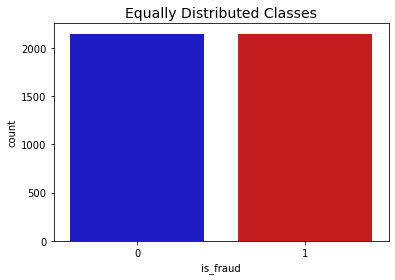

In [40]:
print('Distribution of the fraud in the subsample dataset')
print(new_df['is_fraud'].value_counts()/len(new_df))



sns.countplot('is_fraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [68]:
converted_df = convert_cc_to_cc_type_and_drop(new_df)
converted_df = convert_dob_to_age_and_drop(converted_df)
converted_df = unite_state_city(converted_df)
converted_df['category'] = converted_df['category'].astype('category').cat.codes
converted_df['city'] = converted_df['city'].astype('category').cat.codes
converted_df['job'] = converted_df['job'].astype('category').cat.codes
converted_df['cc_type'] = converted_df['cc_type'].astype('category').cat.codes
converted_df['gender'] = converted_df['gender'].astype('category').cat.codes
converted_df['merchant'] = converted_df['merchant'].astype('category').cat.codes
converted_df['state']=converted_df['state'].astype('category').cat.codes
converted_df

,scaled_amount,scaled_time,trans_date_trans_time,merchant,category,first,last,gender,street,city,...,lat,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,cc_type,age_in_days
481645,-0.068956,0.644135,2020-12-15 09:20:20,501,2,Jeremy,Perry,1,797 Jennifer Loop Suite 634,318,...,43.8295,-93.8282,1087,271,3b5f0fcb3d8dddb5bf1afb4326de6512,43.593336,-93.611379,0,8,20974
403304,12.734533,0.482557,2020-11-26 23:45:54,146,8,Nicholas,Tran,1,672 Randall Burg Suite 551,420,...,43.4512,-71.4890,7430,374,2e4aea8fbf8268177847c4bf901e156f,42.707602,-72.442872,1,1,24059
519314,0.385391,0.716066,2020-12-23 13:55:00,183,6,Jesse,Roberts,1,8415 Vaughn Squares Apt. 788,419,...,43.1960,-72.3001,477,274,d246c6f67bdcd88784f8b3ce86a8e91d,43.714293,-72.739219,0,1,11940
47027,2.382120,-0.770718,2020-07-07 06:43:13,85,4,Dawn,Tucker,0,789 Herring Manors,667,...,29.7736,-95.4034,2906700,95,241f2f78b4dd3fc2b4d1f3722d074411,30.126684,-95.162486,0,5,12987
78632,0.440447,-0.667531,2020-07-19 00:42:56,360,2,Adam,Santos,1,725 Jo Trace Apt. 102,50,...,34.1556,-118.2322,172817,11,3298793bfde48f62e90bc4f6c007186a,35.077526,-119.018215,0,8,13869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550737,-0.498910,0.777385,2020-12-30 13:29:37,664,6,Hannah,Thomas,0,1004 Willis Pass,665,...,34.8698,-100.6806,513,121,f7cead9183f7bdff153864d1d176a8cc,35.390980,-99.944175,0,0,16291
309659,12.450259,0.122019,2020-10-16 22:27:38,119,8,Amanda,Alexander,0,21810 James Mall,654,...,30.9000,-94.7547,99,80,59d5982ec6f77b151a4a2e4b72ac2a3d,31.175112,-94.042457,1,8,20053
20565,0.078359,-0.846518,2020-06-28 15:34:00,505,6,Gail,Weaver,0,979 Stewart Lake,626,...,33.4130,-81.6900,2206,42,e2cfa25922f994bb90f1f7985f309e12,33.438255,-82.026536,0,7,12233
274604,-0.561325,-0.015356,2020-10-01 07:01:55,276,8,Erica,Briggs,0,3310 Davidson Spurs Apt. 107,205,...,38.8938,-86.5246,1228,98,007d23eec0a76c0e72a6d5aa0d84cb6d,38.068719,-87.312204,0,7,10795


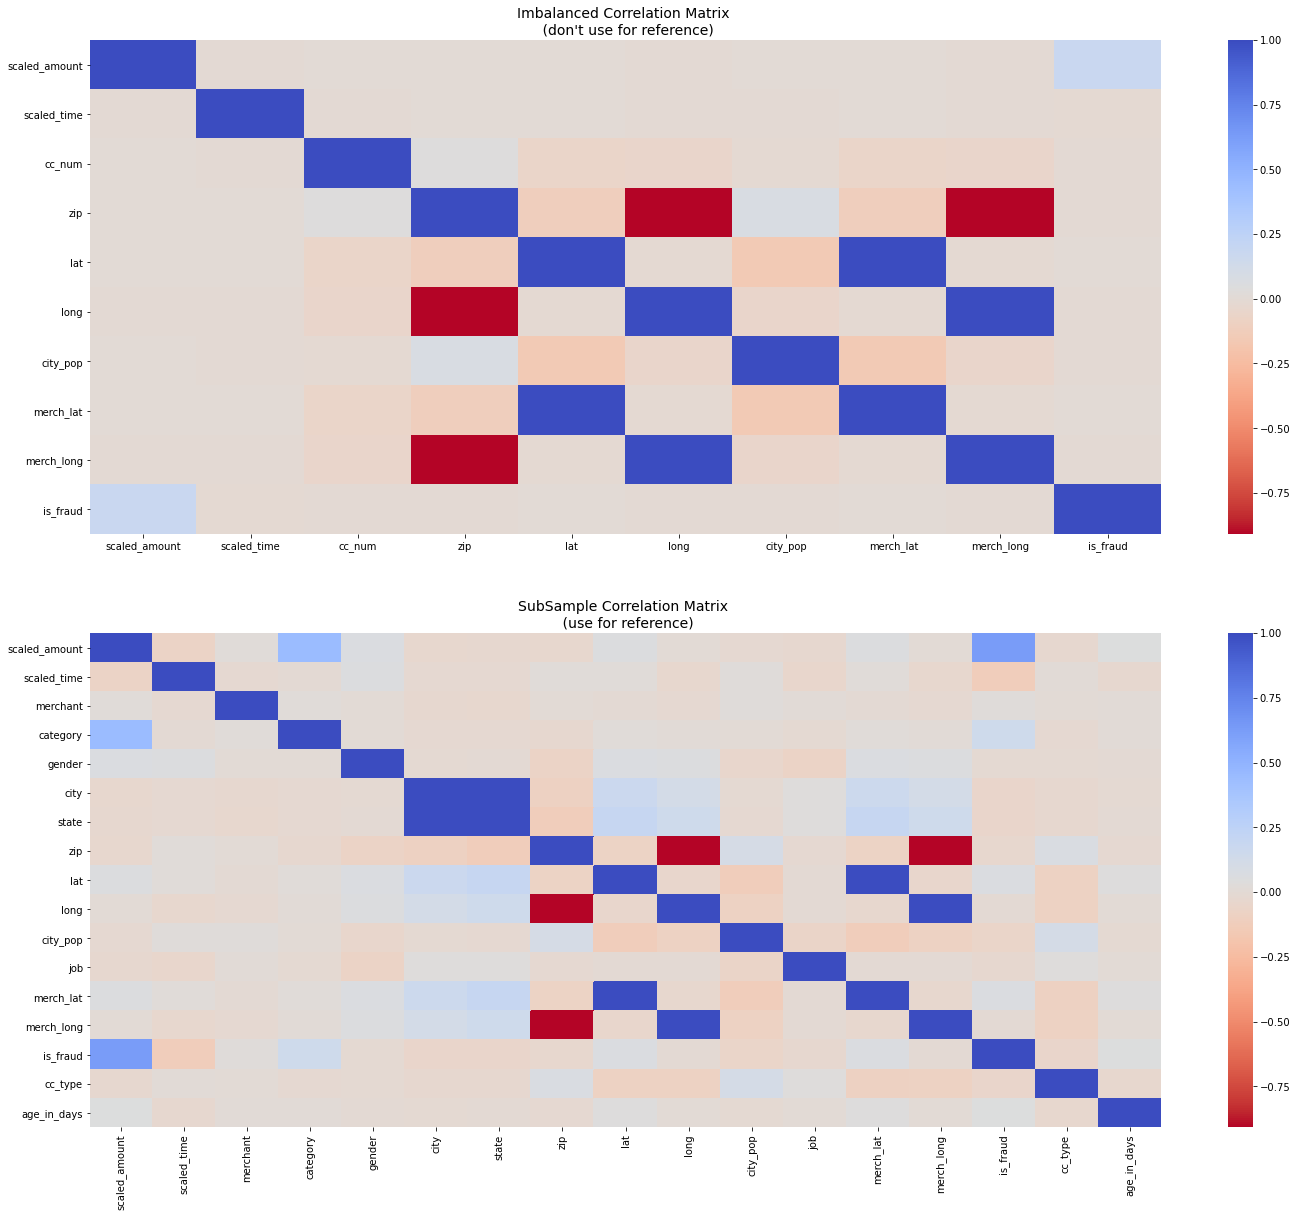

In [69]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = converted_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

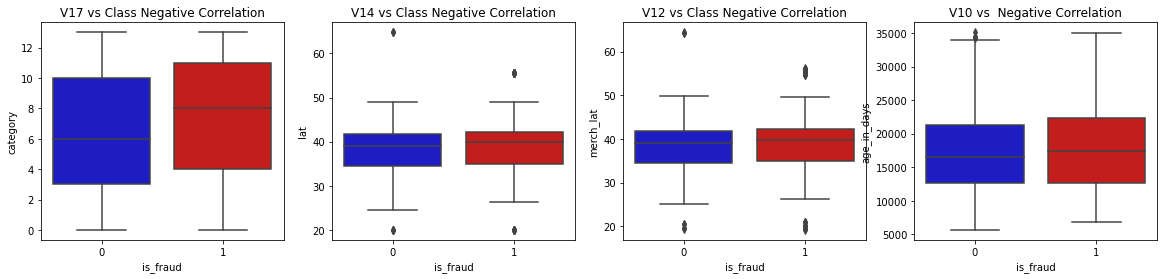

In [60]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="is_fraud", y="category", data=converted_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="is_fraud", y="lat", data=converted_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="is_fraud", y="merch_lat", data=converted_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="is_fraud", y="age_in_days", data=converted_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs  Negative Correlation')

plt.show()

In [70]:
columns_to_drop = ['trans_date_trans_time','first','last','street','trans_num']
converted_df =drop_columns(converted_df,columns_to_drop)
converted_df

,scaled_amount,scaled_time,merchant,category,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cc_type,age_in_days
481645,-0.068956,0.644135,501,2,1,318,22,56068,43.8295,-93.8282,1087,271,43.593336,-93.611379,0,8,20974
403304,12.734533,0.482557,146,8,1,420,29,3220,43.4512,-71.4890,7430,374,42.707602,-72.442872,1,1,24059
519314,0.385391,0.716066,183,6,1,419,29,3601,43.1960,-72.3001,477,274,43.714293,-72.739219,0,1,11940
47027,2.382120,-0.770718,85,4,0,667,41,77007,29.7736,-95.4034,2906700,95,30.126684,-95.162486,0,5,12987
78632,0.440447,-0.667531,360,2,1,50,4,91206,34.1556,-118.2322,172817,11,35.077526,-119.018215,0,8,13869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550737,-0.498910,0.777385,664,6,0,665,41,79237,34.8698,-100.6806,513,121,35.390980,-99.944175,0,0,16291
309659,12.450259,0.122019,119,8,0,654,41,75934,30.9000,-94.7547,99,80,31.175112,-94.042457,1,8,20053
20565,0.078359,-0.846518,505,6,0,626,38,29809,33.4130,-81.6900,2206,42,33.438255,-82.026536,0,7,12233
274604,-0.561325,-0.015356,276,8,0,205,14,47451,38.8938,-86.5246,1228,98,38.068719,-87.312204,0,7,10795


scaled_amount
scaled_time
merchant
category
gender
city
state
zip
lat
long
city_pop
job
merch_lat
merch_long
is_fraud
cc_type
age_in_days


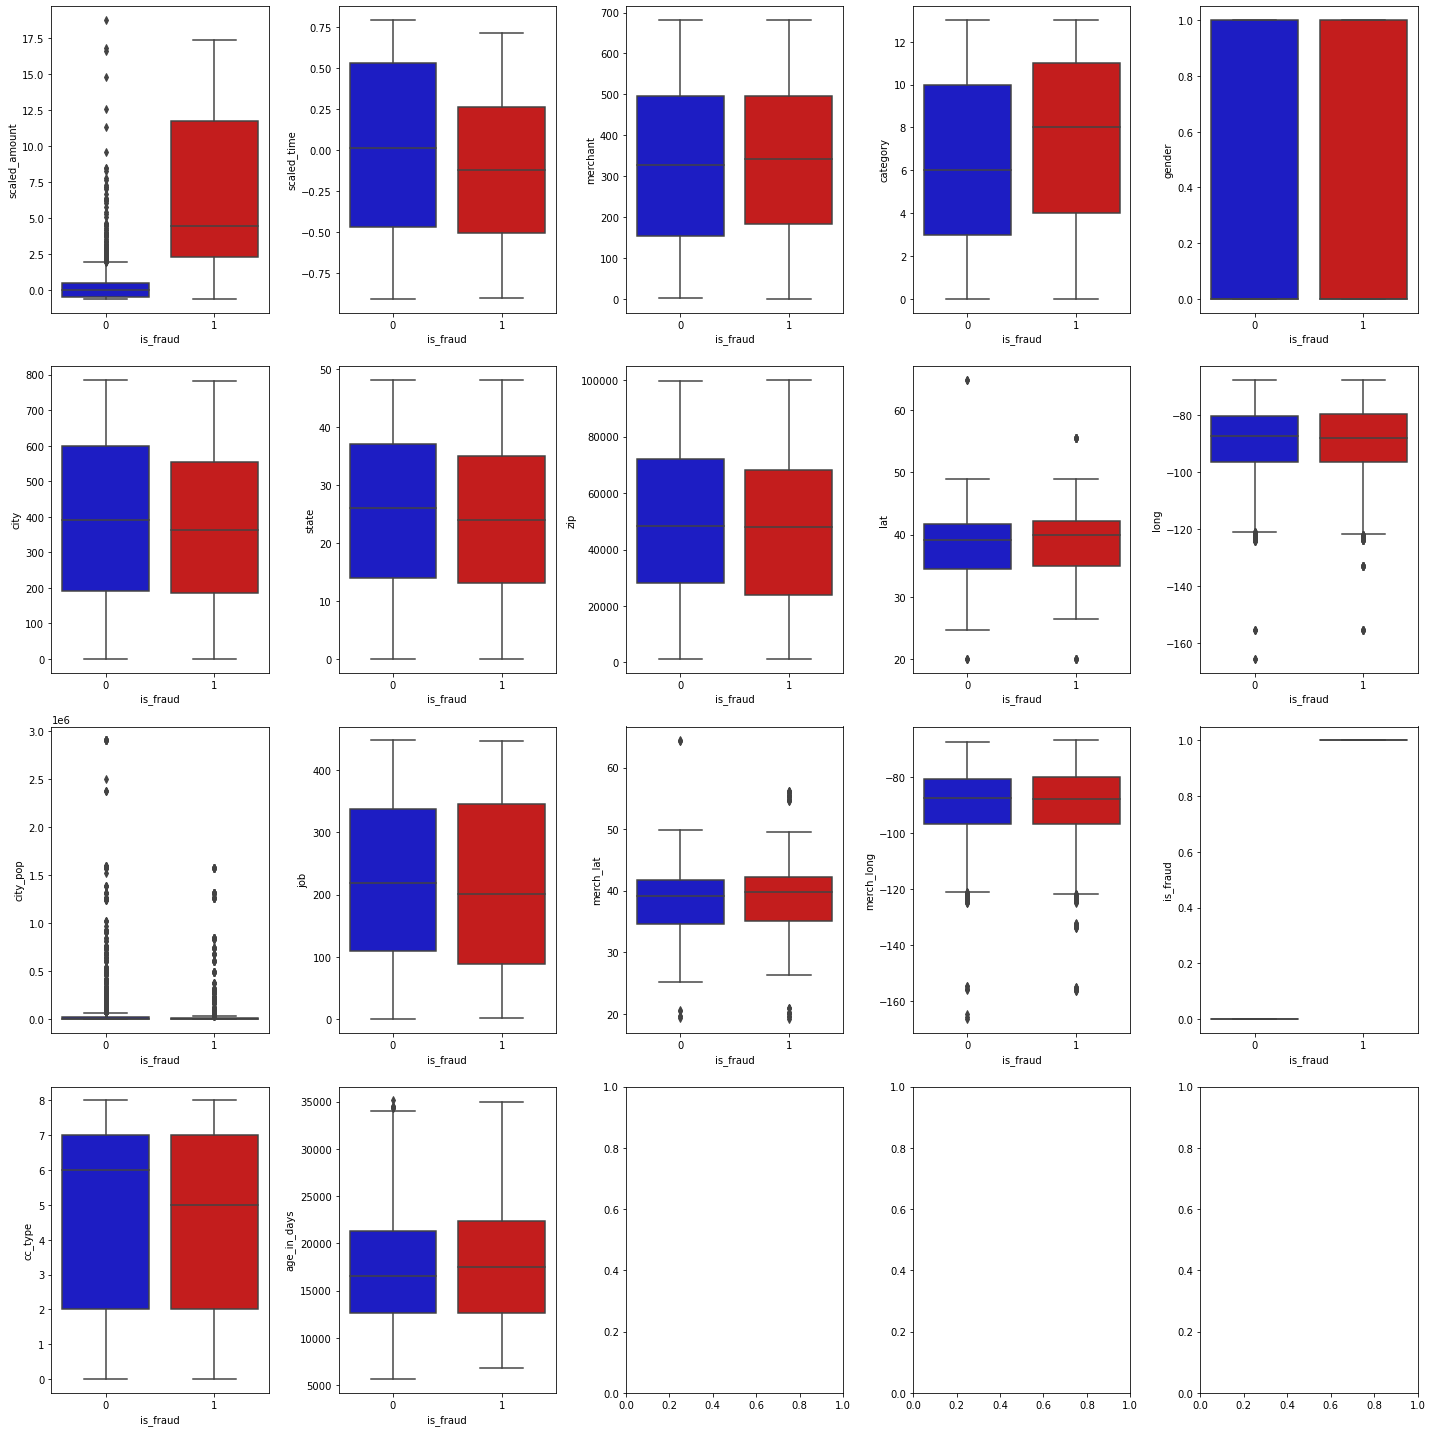

In [74]:


len(converted_df.columns)
converted_df = drop_columns(converted_df,'trans_date_trans_time')
fig, axes = plt.subplots(4,5, figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    if i>len(converted_df.columns)-1:
        break
    print(converted_df.columns[i])

    sns.boxplot(x="is_fraud", y=converted_df.columns[i], data=converted_df, palette=colors, ax=ax)
#     ax.set_title("{} vs Class Negative Correlation".format(y=converted_df.columns[i]))

plt.tight_layout()
plt.show()

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

In [ ]:
pd.concat([fraud.amt.describe(), normal.amt.describe()], keys=["fraud_amt", "non_fraud_amt"], axis=1)

In [ ]:
### plot all the features via seaborn ### 
percent = 0.01
columns_to_drop = ['trans_date_trans_time','state','zip','lat','long','first','last','street','trans_num','unix_time']
partial_data = get_partial_data(data,percent)
partial_data = drop_columns(partial_data,columns_to_drop)
partial_data

In [ ]:
sns.pairplot(partial_data, hue='is_fraud') 

In [ ]:
##### atm #####
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

## Conclusion
We can see that transaction's amount is a good feature for fraud transaction recognition

In [ ]:
### atm via seaborn ###
plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
sns.catplot(x='is_fraud',y='amt', hue='is_fraud',data=data)

In [ ]:
##### time #####

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud_24time = fraud.copy()
fraud_24time.unix_time = fraud_24time.unix_time % 86400 #(86400s per 24h)
fraud_24time.unix_time /= (86400/24)
fraud_24time.unix_time.hist(bins=50,label="Fraudulant Transaction",weights=np.ones(len(fraud_24time)) / len(fraud_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.xlabel("")
plt.legend()

plt.subplot(2, 1, 2)
normal_24time = normal.copy()
normal_24time.unix_time  = normal_24time.unix_time  % 86400 #(86400s per 24h)
normal_24time.unix_time  /= (86400/24)
normal_24time.unix_time .hist(bins=50,label="Non Fraudulant Transaction",weights=np.ones(len(normal_24time)) / len(normal_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.legend()

## Conclusion
We can see that transaction's time is a good feature for fraud transaction recognition

In [ ]:
##### category #####
category_df = pd.concat([fraud.category.value_counts()/len(fraud.index), normal.category.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))

category_df.plot(kind='bar',ax=axes)

## Conclusion
We can see that transaction category is a good feature for fraud recognition

In [ ]:
##### city #####
np.set_printoptions(suppress=True)
dropped = data.drop_duplicates(["city"], inplace=False)
total_pupulation = dropped.city_pop.sum()

dropped.city_pop = dropped.city_pop / total_pupulation
dropped.index  = dropped.city
dropped

city_df = pd.concat(
    [
        fraud.city.value_counts()/len(fraud.index), 
        normal.city.value_counts()/len(normal.index),
        # dropped.city_pop
    ], 
    # keys=["fraud", "normal", "normalized_pop"], 
    keys=["fraud", "normal"], 
    axis=1)

city_df

# /total_pupulation
# dropped.city_pop.value_counts()

# grouped = data.groupby('city')
# data.city.unique()
# data.loc['city', data.city.unique()]

# data.city_pop.sum()
fig, axes = plt.subplots(1, 1, figsize=(20,10))
city_df.plot(kind='bar',ax=axes)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("50 cities with high fraud distribution")
city_df[:50].plot(kind='bar',ax=axes)


In [ ]:
city_df.index[0]
city_count = {}
for i in range(50):
    fraud_city = fraud[fraud['city']==city_df.index[i]]
    lat_unique = fraud_city.lat.nunique()
    long_unique = fraud_city.long.nunique()
    city_count[city_df.index[i]]= lat_unique > 1  or long_unique > 1

city_count

## Conclusion
We can see that location of card holder is not a good feature to recognize fraud.

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 50))

for i, ax in enumerate(axes.ravel()):
    fraud_city =  fraud[fraud['city']==city_df.index[i]]
    normal_city =  normal[normal['city']==city_df.index[i]]
    ax.scatter(normal_city.merch_lat, normal_city.merch_long, label="Normal", alpha=1,color='green')
    ax.scatter(fraud_city.merch_lat, fraud_city.merch_long,label='Fraud', alpha=1, color='red',s=400)
    ax.legend()
    feature_name = city_df.index[i]
    ax.set_title("{}".format(feature_name), fontdict=title_font)
    ax.grid()
    
plt.tight_layout()


## Conclusion
Above we plot the locations of merchant in the cities with the highest fraud density. As we can see, there is no pattern and merchan location is not a good feature to recognize the fraud. 

In [ ]:
### population ###

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.city_pop.hist(bins=50,label="Fraudulant City Population",density=True,color='red')
plt.legend()

plt.subplot(2, 1, 2)
normal.city_pop.hist(bins=50,label="Non Fraudulant City Population",density=True,color='green')
plt.legend()

## Conclusion
We can see that city population is not a good feature to distinguish between a fraud and normal transaction. 

In [ ]:
### zip code ### 
fraud.zip
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.zip.hist(bins=50,label="Fraudulant Zip",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.zip.hist(bins=50,label="Non Fraudulant Transaction",density=True)
plt.legend()

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
orig_zip = data['zip']
label = data['is_fraud']
data_no_label = drop_columns(data,'is_fraud')
te = TargetEncoder(cols='zip',return_df=True, drop_invariant = True).fit(data_no_label,label)
transformed = te.transform(data_no_label)
data['zip'] = transformed['zip'] # replace zip with fraud probability per zip

In [ ]:
zip_db = pd.concat([orig_zip,transformed['zip'],label], axis=1, keys=['orig_zip', 'fraud_probability','label'])
zip_faud_prob = pd.DataFrame(zip_db.groupby('orig_zip')['fraud_probability'].mean())
zip_faud_prob.sort_values(by='fraud_probability',ascending = False, inplace = True)

fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Fraud probability per zip-code")
zip_faud_prob.plot(kind='bar',ax=axes,logy=True,rot = 45)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Zipcodes with the highest Fraud probability")
zip_faud_prob[:50].plot(kind='bar',ax=axes,rot = 45)

## Conclusion
We can see that there are zipcodes with high probability of fraud, therefore zipcode is a good feature to distinguish between a fraud and normal transaction. 

In [ ]:
##### state #####
state_df = pd.concat(
    [
        fraud.state.value_counts()/len(fraud.index), 
        normal.state.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Distribution of card holders per state")
state_df.plot(kind='bar',ax=axes)

In [ ]:
##### gender #####
gender_df = pd.concat(
    [
        fraud.gender.value_counts()/len(fraud.index), 
        normal.gender.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

gender_df.plot(kind='bar',ax=axes)

## Conclusion
As we can see, gender is not significally vary between fraud and normal card holders.

In [ ]:
##### job #####
job_db = pd.concat(
    [
        fraud.job.value_counts()/len(fraud.index), 
        normal.job.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

job_db.plot(kind='bar',ax=axes)

## Conclusion
We can see that job is a good feature for fraud recognition

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(lon2-lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
    return np.round(res, 2)

def calculate_holder_merch_distance(df):
    _df = df.copy()
    dist_list = []
    
    for index, row in df.iterrows():
        dist = haversine_distance(row['lat'],row['long'],row['merch_lat'],row['merch_long'])
        dist_list.append(dist)
    _df['holder_merch_dist'] = dist_list
    return _df

In [ ]:
### location ### 

fraud  = calculate_holder_merch_distance(fraud)
normal = calculate_holder_merch_distance(normal)

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.holder_merch_dist.hist(bins=50,label="Fraudulant Distance",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.holder_merch_dist.hist(bins=50,label="Non Fraudulant Distance",density=True)
plt.legend()


## Conclusion
We can see that distance between card holder location and merchant location is not a good feature for fraud recognition

In [ ]:
##### card type #####
card_type_df = pd.concat([fraud.cc_type.value_counts()/len(fraud.index), normal.cc_type.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
card_type_df.plot(kind='bar',ax=axes)

In [ ]:
### avrg amount per card type ### 
fraud_avrg_card_amt = fraud.groupby('cc_type')['amt'].mean()
normal_avrg_card_amt = normal.groupby('cc_type')['amt'].mean()
amt_per_category = pd.concat([fraud_avrg_card_amt, normal_avrg_card_amt], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
amt_per_category.plot(kind='bar',ax=axes)

## Conclusion
We can see that card type is not a good feature for fraud recognition

In [ ]:
##### merchant #####
merch_type_df = pd.concat([fraud.merchant.value_counts()/len(fraud.index), normal.merchant.value_counts()//len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Merchant")
merch_type_df.plot(kind='bar',ax=axes)

In [ ]:
num = 20
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("{} {} {}".format("Top", num, "of fraud merchant"))
merch_type_df[:num].plot(kind='bar',ax=axes)

## Conclusion 
We can see that there are merchants that has only fraud transactions. 
## TBD 
What we can conclude from this? Should we take into account specific merchant when we train the model? It's heavy feature - 693 unique categories. We have to OneHot it, means +693 columns 

In [ ]:
### dob ###
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.age_in_days.hist(bins=100,label="Fraudulant Age",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.age_in_days.hist(bins=100,label="Non Fraudulant Age",density=True)
plt.legend()



## Conclusion
We can see that age is not a good feature for fraud recognition

In [ ]:
### average amt per category ### 
fraud_avrg_amt = fraud.groupby('category')['amt'].mean()
normal_avrg_amt = normal.groupby('category')['amt'].mean()
amt_per_category = pd.concat([fraud_avrg_amt, normal_avrg_amt], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
amt_per_category.plot(kind='bar',ax=axes)

## Conclusion
We can see that there is significant difference between average amount of transactions made in each category between fraud and normal card holder. Also we can see that the most fraud transaction are made in the Internet.

In [ ]:
plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(data.corr(),square = True,  vmax=0.8)

In [ ]:
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

In [ ]:
df_test = read_test_data()
df_test = convert_to_categorical_trans_date_and_drop(df_test)
# get_categorical_features(df_test).columns

df_test.amt.describe()

In [ ]:
fig, axes = plt.subplots(11, 1, figsize=(20, 70))
continuous_features = get_continuous_features(df_test)

for i, ax in enumerate(axes.ravel()):
    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = continuous_features[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Counts", fontdict=labels_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 70))
x = df_test.is_fraud

for i, ax in enumerate(axes.ravel()):
    X_col = continuous_features.iloc[:, i]
#     ax.set_xlim(0, 1)
    ax.set_xlim(right=1)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(x, X_col, alpha=.5)

    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
#     ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

In [ ]:
categorical_features = get_categorical_features(df_test)


fig, axes = plt.subplots(3, 3, figsize=(30,60))
for i, ax in enumerate(axes.ravel()):
    if(i >= len(categorical_features.columns)):
        break
    categorical_features.iloc[:,i].value_counts().plot(kind='bar',ax=ax,rot=45)
    ax.set_title(categorical_features.columns[i])

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

In [ ]:
# pay attention: train data contains 1.300.000 samples
percent = 0.2 # 20%
partial_data = get_partial_data(data,percent)
print ("data size: {}\npercent: {:.2f}\npartial_data size {}".format(len(data.index),percent,len(partial_data.index)))
partial_data

In [ ]:
colums_to_drop = ['cc_num','gender','first','last','street','trans_num','merch_lat','merch_long','dob','lat','long','city_pop','merchant','state','trans_date_trans_time','unix_time']
partial_data= drop_columns(partial_data,colums_to_drop)
partial_data

In [ ]:
categorical = partial_data.dtypes == object
ohe = ColumnTransformer([('encoder', OneHotEncoder(), categorical)], remainder='passthrough')
transformed = pd.DataFrame.sparse.from_spmatrix(ohe.fit_transform(partial_data),columns=ohe.get_feature_names()) #TBD fix names of columns to human-readable
transformed

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.